In [1]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout,
    GlobalAveragePooling2D, Activation, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam




In [3]:
 import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import sobel
from skimage.filters import scharr

In [7]:
data_dir = 'D:/SPOORTHI/Herlev DataSet/Herlev Dataset/train_segmented'
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
train_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation')

Found 518 images belonging to 7 classes.
Found 125 images belonging to 7 classes.


In [9]:
from tensorflow.keras.models import Model


def fire_module(x, squeeze_filters, expand_filters):
    """
    A Fire module with squeeze and expand operations.

    Args:
        x: Input tensor.
        squeeze_filters: Number of filters for the squeeze layer.
        expand_filters: Number of filters for the expand layer.

    Returns:
        Output tensor after the fire module.
    """
    # Squeeze operation
    squeeze = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='valid')(x)
    squeeze = BatchNormalization()(squeeze)

    # Expand operation
    expand_1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='valid')(squeeze)
    expand_3x3 = Conv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeeze)

    # Concatenate the 1x1 and 3x3 expansions
    output = Concatenate()([expand_1x1, expand_3x3])
    output = BatchNormalization()(output)

    return output

In [11]:
def build_improved_squeezenet(input_shape=(128, 128, 3), num_classes=7):
    """
    Builds the Improved SqueezeNet model.

    Args:
        input_shape: Shape of the input images (default is (128, 128, 3)).
        num_classes: Number of output classes.

    Returns:
        A compiled SqueezeNet model.
    """
    input_layer = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv2D(96, (3, 3), strides=(2, 2), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Fire modules
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=16, expand_filters=64)
    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=32, expand_filters=128)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=48, expand_filters=192)
    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    x = fire_module(x, squeeze_filters=64, expand_filters=256)
    x = Dropout(0.5)(x)  # Regularization

    # Output layers
    x = Conv2D(num_classes, (1, 1), activation='relu', padding='valid')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    output_layer = Activation('softmax')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:
if __name__ == "__main__":
    # Define model
    model = build_improved_squeezenet(input_shape=(128, 128, 3), num_classes=7)

    # Display model architecture
    model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      2,688 │ input_layer[0][0] │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        384 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      1,552 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      1,088 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      9,280 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_2[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      2,064 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │      1,088 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      9,280 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ concatenate_1[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      4,128 │ batch_normalizat

 Total params: 739,427 (2.82 MB)

 Trainable params: 733,461 (2.80 MB)

 Non-trainable params: 5,966 (23.30 KB)

In [15]:
from tensorflow.keras.optimizers import Optimizer
import tensorflow as tf

class GazelleOptimizer(Optimizer):
    def __init__(self, learning_rate=0.001, beta=0.9, name="GazelleOptimizer", **kwargs):
        # Pass learning_rate as the first argument to the parent constructor
        super().__init__(learning_rate=learning_rate, name=name, **kwargs)

        # Store other parameters
        self.learning_rate = learning_rate
        self.beta = beta

    def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
        # Custom gradient application logic
        pass

    def get_config(self):
        # Configuration for saving/loading the optimizer
        config = {
            'learning_rate': self.learning_rate,
            'beta': self.beta
        }
        base_config = super(GazelleOptimizer, self).get_config()
        return {**base_config, **config}

In [17]:
gazelle_optimizer = GazelleOptimizer(learning_rate=0.001, beta=0.9)
model.compile(optimizer=gazelle_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Build and compile the model
model_squeezenet = build_improved_squeezenet(input_shape=(128, 128, 3), num_classes=7)
model_squeezenet.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
history_squeezenet = model_squeezenet.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[tensorboard_callback]
)

C:\Users\Govindu Vijay Kumar\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.1886 - loss: 1.8762 - val_accuracy: 0.1680 - val_loss: 1.9709
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3592 - loss: 1.6356 - val_accuracy: 0.1680 - val_loss: 2.0568
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3983 - loss: 1.5719 - val_accuracy: 0.1680 - val_loss: 2.1571
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5038 - loss: 1.5133 - val_accuracy: 0.1040 - val_loss: 2.2489
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5386 - loss: 1.3616 - val_accuracy: 0.1040 - val_loss: 2.3261
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6185 - loss: 1.2638 - val_accuracy: 0.1040 - val_loss: 2.1878
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5912 - loss: 1.2915 - val_accuracy: 0.0640 - val_loss: 2.1402
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7154 - loss: 1.1169 - val_accuracy: 0.1040 - val_loss:

In [22]:
def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
    # Example: Apply gradient updates based on custom logic.
    # grads_and_vars is a list of (gradient, variable) pairs
    for grad, var in grads_and_vars:
        # Custom logic to apply gradients, e.g., using beta, learning_rate, etc.
        new_grad = grad * self.learning_rate  # Modify this logic as needed
        # Apply the updated gradient to the variable
        var.assign_sub(new_grad)  # Apply update (could be gradient descent or other methods)

In [23]:
# Compile the model with GazelleOptimizer
model_squeezenet.compile(
    optimizer=gazelle_optimizer,  # Use GazelleOptimizer here
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [24]:
# Instantiate the GazelleOptimizer
gazelle_optimizer = GazelleOptimizer(learning_rate=0.001, beta=0.9)

# Compile the model with GazelleOptimizer
model_squeezenet.compile(
    optimizer=gazelle_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_squeezenet = model_squeezenet.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[tensorboard_callback]
)


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 494ms/step - accuracy: 0.9921 - loss: 0.1983 - val_accuracy: 0.3920 - val_loss: 1.6711
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 443ms/step - accuracy: 0.9933 - loss: 0.1678 - val_accuracy: 0.3920 - val_loss: 1.6725
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 408ms/step - accuracy: 0.9861 - loss: 0.1935 - val_accuracy: 0.4000 - val_loss: 1.6760
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - accuracy: 0.9931 - loss: 0.1799 - val_accuracy: 0.3920 - val_loss: 1.6784
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 401ms/step - accuracy: 0.9959 - loss: 0.1665 - val_accuracy: 0.3920 - val_loss: 1.6795
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 443ms/step - accuracy: 0.9869 - loss: 0.1867 - val_accuracy: 0.3920 - val_loss: 1.6822
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 430ms/step - accuracy: 0.9941 - loss: 0.1830 - val_accuracy: 0.4000 - val_loss: 1.6842
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step - accuracy: 0.9925 - loss: 0.1778 - val_accuracy: 0

In [25]:
print(model_squeezenet.optimizer)


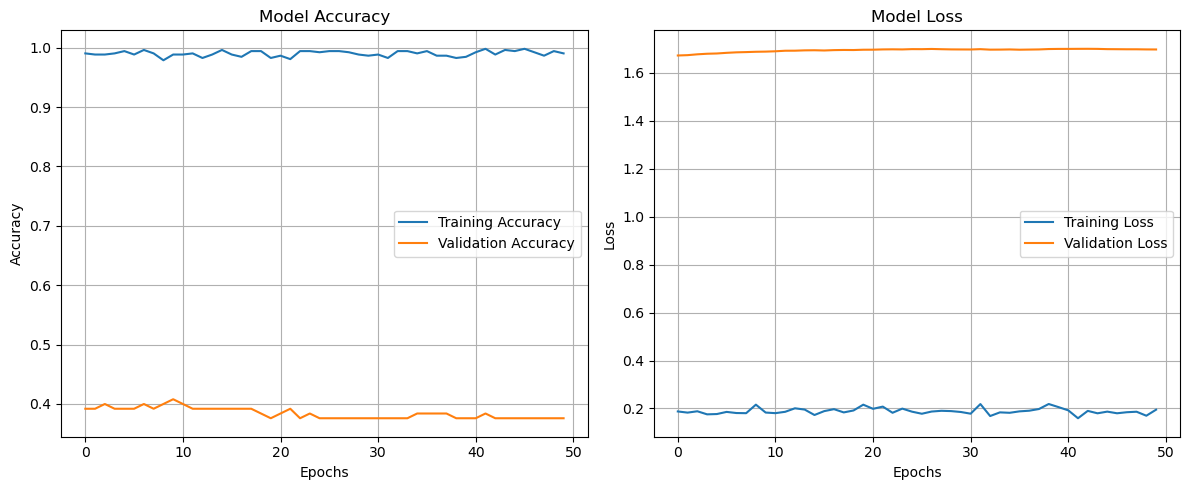

In [42]:
import matplotlib.pyplot as plt

# Extract training history
history = history_squeezenet.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy graph
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss graph
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Show the plots
plt.tight_layout()
plt.show()


In [40]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the test image
test_image_path = "D:/SPOORTHI/Herlev DataSet/Herlev Dataset/test/carcinoma_in_situ/149316117-149316122-004.bmp"

# Preprocess the test image
def preprocess_image(image_path, target_size=(128, 128)):
    """
    Preprocesses an image for model prediction.
    
    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for resizing the image.
    
    Returns:
        np.array: Preprocessed image tensor.
    """
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Rescale pixel values (if applicable, e.g., divide by 255 for normalization)
    img_array = img_array / 255.0
    # Add batch dimension (model expects batches of images)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Define the mapping of class indices to labels
index_to_class = {
    5: "Normal Superficial",
    4: "Normal Intermediate",
    3: "Normal Columnar",
    1: "Light Dysplasia",
    2: "Moderate Dysplasia",
    6: "Severe Dysplasia",
    0: "Carcinoma in situ"
}

# Preprocess the test image
test_image = preprocess_image(test_image_path)

# Make a prediction
predictions = model_squeezenet.predict(test_image)

# Get the predicted class index
predicted_class = np.argmax(predictions, axis=1)[0]

# Get the predicted label using the mapping
predicted_label = index_to_class[predicted_class]

# Print the results
print(f"Predicted class probabilities: {predictions}")
print(f"Predicted class index: {predicted_class}")
print(f"Predicted label: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted class probabilities: [[0.4848051  0.0484794  0.04379137 0.19549792 0.04124673 0.09531576
  0.09086369]]
Predicted class index: 0
Predicted label: Carcinoma in situ


In [47]:
def evaluate_model(model, generator):
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    cr = classification_report(y_true, y_pred_classes, target_names=generator.class_indices.keys())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=generator.class_indices.keys(), yticklabels=generator.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print('Classification Report:')
    print(cr)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step


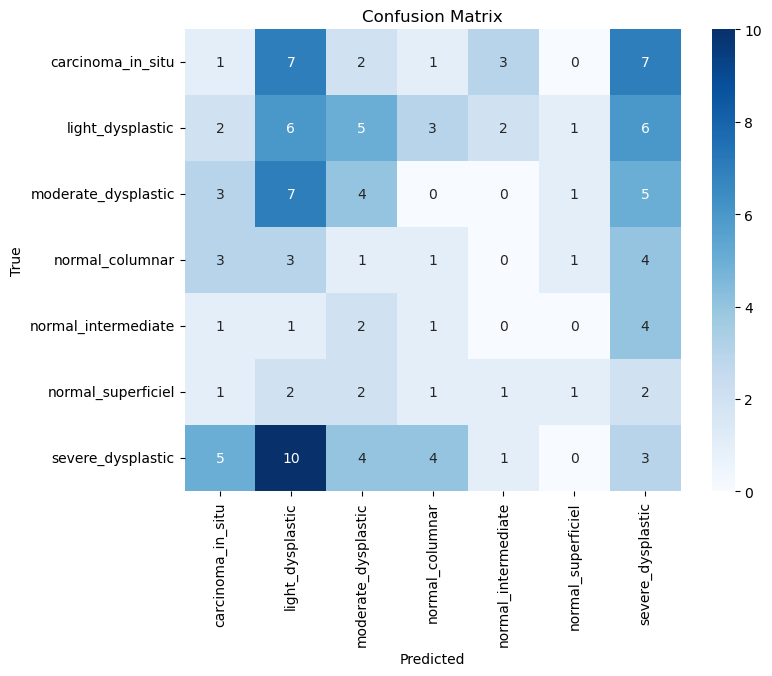

Classification Report:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.06      0.05      0.05        21
   light_dysplastic       0.17      0.24      0.20        25
moderate_dysplastic       0.20      0.20      0.20        20
    normal_columnar       0.09      0.08      0.08        13
normal_intermediate       0.00      0.00      0.00         9
 normal_superficiel       0.25      0.10      0.14        10
  severe_dysplastic       0.10      0.11      0.10        27

           accuracy                           0.13       125
          macro avg       0.12      0.11      0.11       125
       weighted avg       0.13      0.13      0.12       125



In [49]:
evaluate_model(model_squeezenet, val_generator)